In [1]:
# Optimizer settings
num_workers = 2
budget = 16
algorithm = 'OnePlusOne'

In [2]:
import re
from tempfile import TemporaryDirectory, NamedTemporaryFile

import pandas as pd
import matplotlib.pyplot as plt

from dask.distributed import LocalCluster, Client
import nevergrad as ng
import hiplot as hip
from SALib.analyze import delta

from calibrations.matsch_b2 import obs, model, targets, loss, variables

In [3]:
cluster = LocalCluster(n_workers=2)
client = Client(cluster)

Before optimization loss is 0.5346239095337596


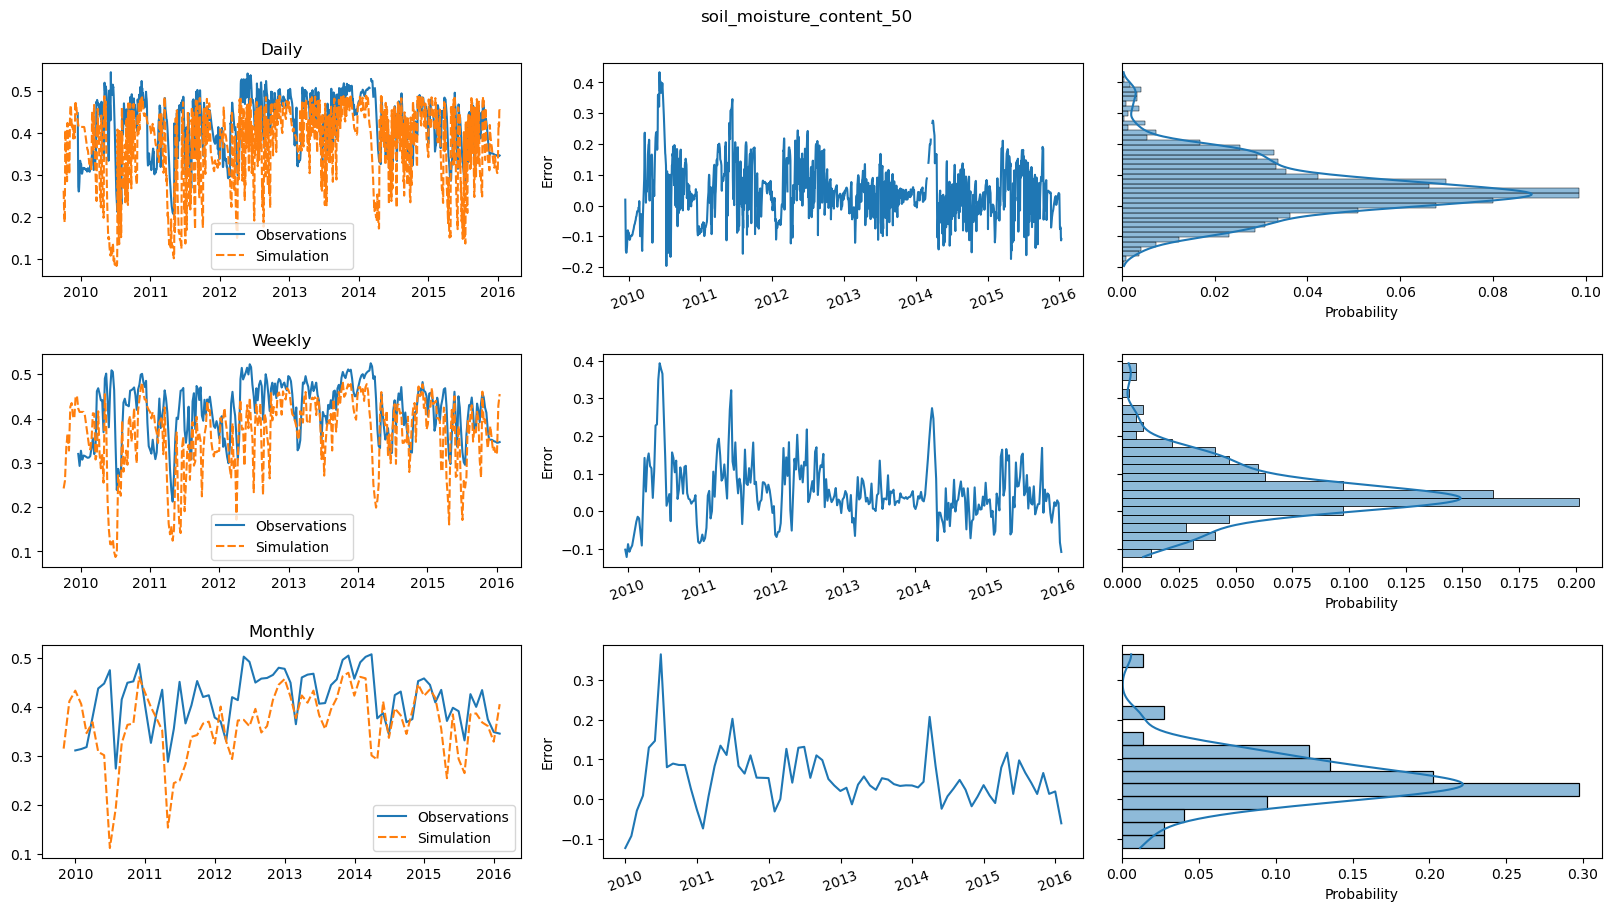

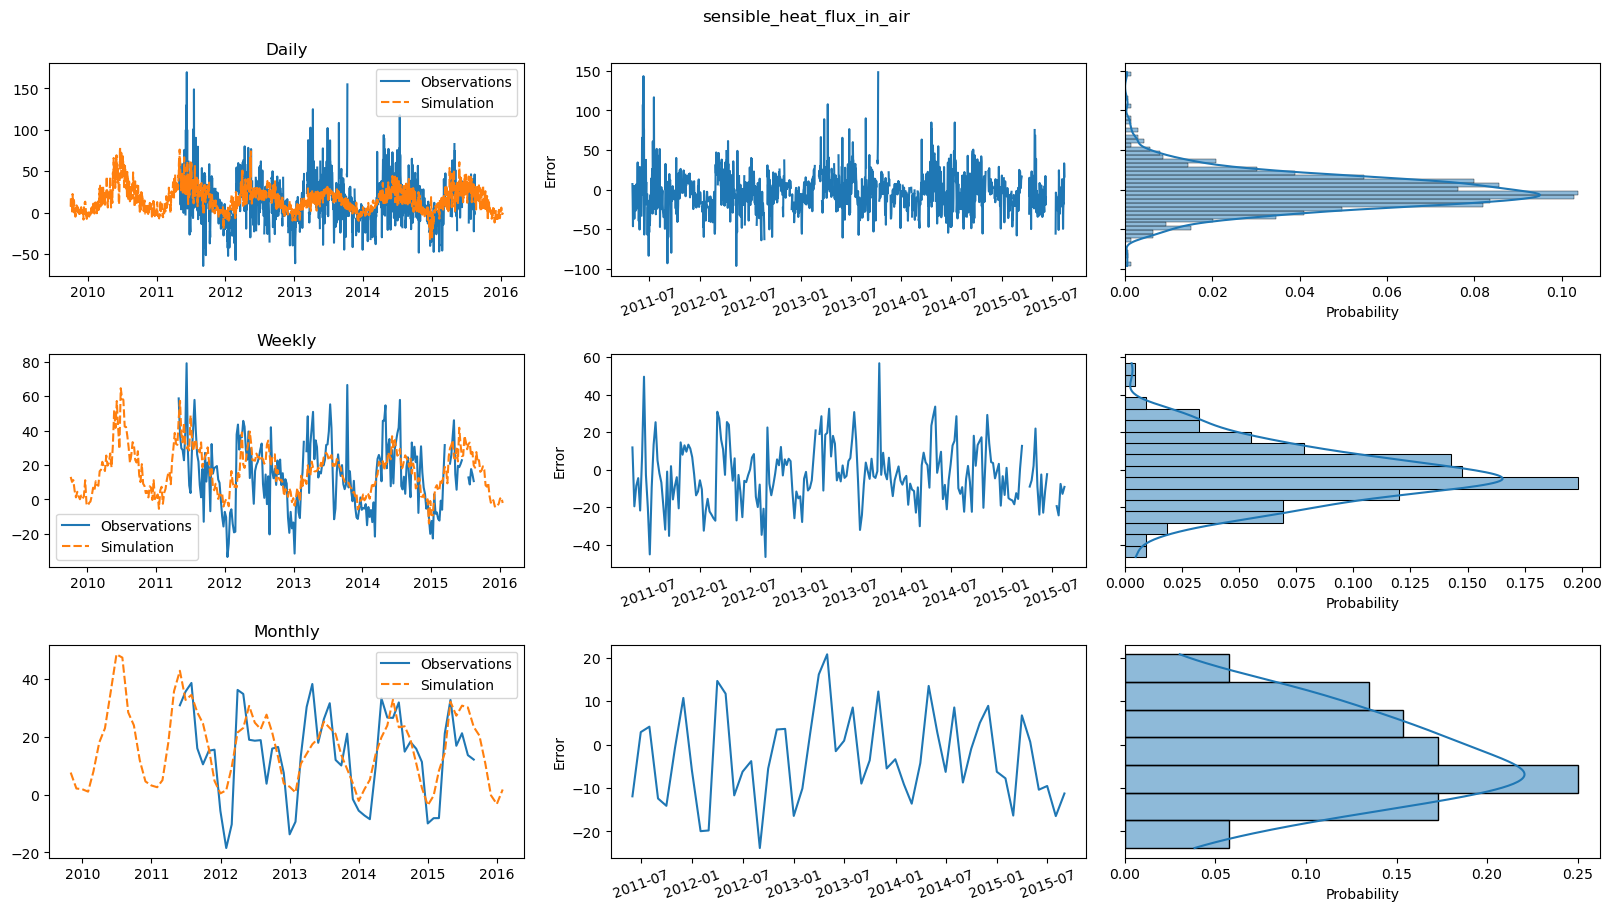

In [4]:
with TemporaryDirectory() as tmpdir:
    sim = model.eval(tmpdir)
    print(f"Before optimization loss is {loss(sim=sim)}")
    for t in targets:
        obs.compare(t, sim, desc=t)
        plt.show()

In [4]:
kwargs = {name: ng.p.Scalar(init=value.suggested, lower=value.lower, upper=value.upper) 
          for name, value in variables.iterrows()}

optimizer = ng.optimizers.registry[algorithm](parametrization=ng.p.Instrumentation(**kwargs),
                                              budget=budget,
                                              num_workers=num_workers)

logfile = NamedTemporaryFile()
logger = ng.callbacks.ParametersLogger(logfile.name)
optimizer.register_callback("tell",  logger)

optimizer.register_callback("tell", ng.callbacks.ProgressBar())

recommendation = optimizer.minimize(loss, executor=client, batch_mode=False)

In [5]:
samples = pd.DataFrame(logger.load())

samples.dropna(subset=['#loss'], inplace=True)
points = samples[variables.index].to_numpy()
losses = samples['#loss'].to_numpy()

problem = {'num_vars': variables.shape[0],
           'names': variables.index,
           'bounds': list(zip(variables.lower, variables.upper))}

SA = delta.analyze(problem, points, losses)

variables['best'] = pd.Series(recommendation.kwargs)

pd.concat([variables, SA.to_df()], axis=1).sort_values('S1', ascending=False)

,suggested,lower,upper,type,best,delta,delta_conf,S1,S1_conf
name,,,,,,,,,
RootDepth,500.00000,50.00000,1000.00000,scalar,157.043498,0.378060,0.154502,0.656850,0.304763
NormalHydrConductivity,-2.00000,-4.30103,0.00000,log,-3.480422,0.251830,0.186455,0.479430,0.369098
NVanGenuchten,1.50000,1.15000,2.00000,scalar,1.220139,0.136638,0.144262,0.453147,0.273689
VegReflectVis,0.10000,0.05000,0.20000,scalar,0.191640,0.210733,0.130754,0.407822,0.331622
SoilRoughness,100.00000,10.00000,500.00000,scalar,63.267164,0.166491,0.138108,0.382989,0.326855
SoilEmissiv,0.90000,0.80000,1.00000,scalar,0.913273,0.065394,0.157394,0.252385,0.381301
MinStomatalRes,50.00000,10.00000,100.00000,scalar,50.829079,0.296960,0.163134,0.227915,0.284334
CanopyFraction,0.60000,0.00000,1.00000,scalar,0.883516,0.050489,0.126070,0.210826,0.330358
VegTransVis,0.02000,0.00500,0.15000,scalar,0.007918,0.063426,0.167807,0.208683,0.296303


In [6]:
experiment = logger.to_hiplot_experiment()

hidden_columns = ['uid', 
                  'from_uid', 
                  '#parametrization',
                  '#session', 
                  '#lineage',
                  '#meta-sigma']

for name in variables.index:
    hidden_columns.append(name + '#sigma')
    hidden_columns.append(name + '#sigma#sigma')

hidden_columns += [col for col in samples.columns if re.match(r"(#optimizer).*", col)]

table = experiment.display_data(hip.Displays.TABLE)
table.update({'hide': hidden_columns,
              'order_by': [['#num-tell', 'asc']]})

plot = experiment.display_data(hip.Displays.PARALLEL_PLOT)
plot.update({'hide': [*hidden_columns, '#num-tell'],
             'order': ['#generation', *variables.index, '#loss']})

experiment.display()

<IPython.core.display.Javascript object>

After optimization loss is 0.47464248781693025


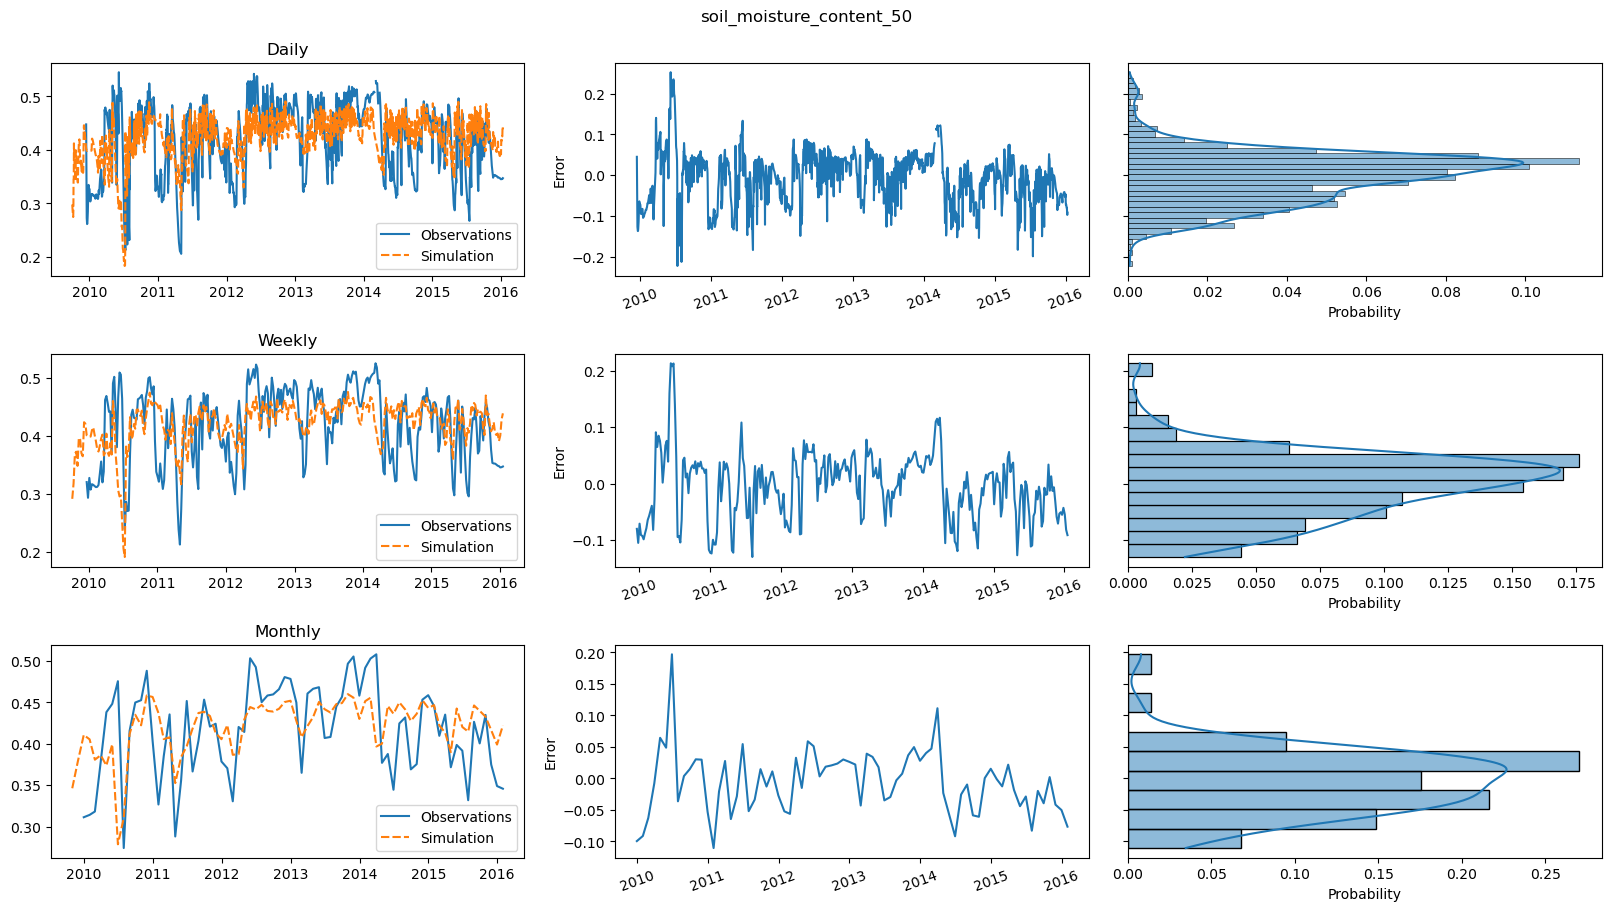

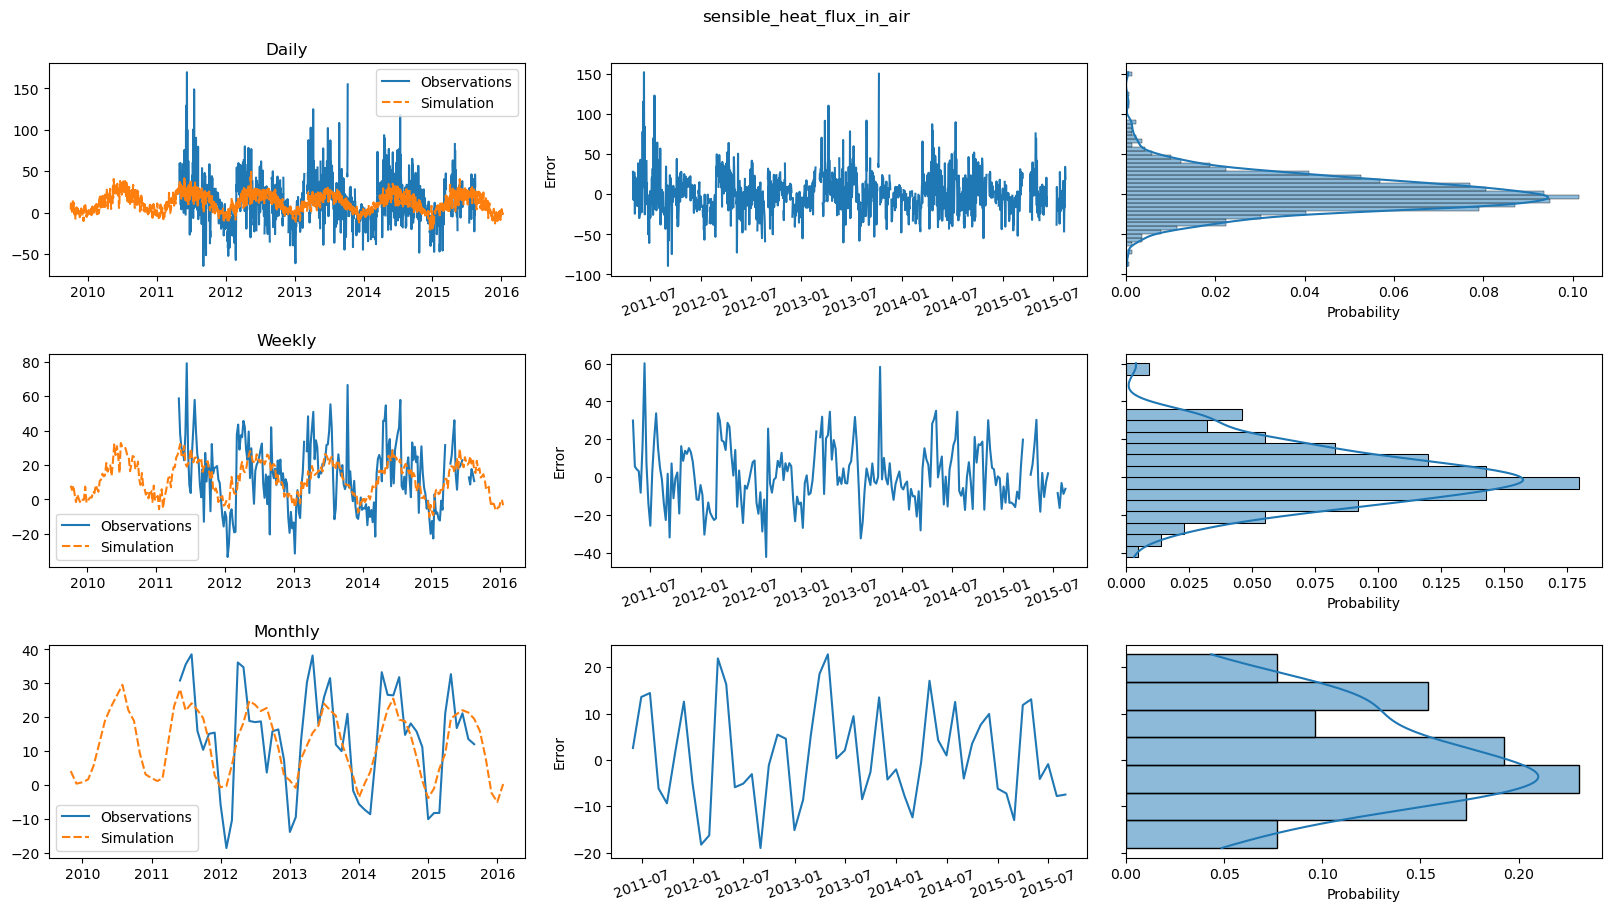

In [7]:
with TemporaryDirectory() as tmpdir:
    print(f"After optimization loss is {recommendation.loss}")
    sim = model.eval(tmpdir, **recommendation.kwargs)
    for t in targets:
        obs.compare(t, sim, desc=t)
        plt.show()